# 初めにお読みください。

このシートを動かすためには、事前にCSVデータをダウンロードする必要があります。

データファイルを直接curl等でダウンロードできないため、まず、ブラウザで  
[https://docs.google.com/spreadsheets/d/e/2PACX-1vSe-8lf6l_ShJHvd126J-jGti992SUbNLu-kmJfx1IRkvma_r4DHi0bwEW89opArs8ZkSY5G2-Bc1yT/pub?gid=0&single=true&output=csv](https://docs.google.com/spreadsheets/d/e/2PACX-1vSe-8lf6l_ShJHvd126J-jGti992SUbNLu-kmJfx1IRkvma_r4DHi0bwEW89opArs8ZkSY5G2-Bc1yT/pub?gid=0&single=true&output=csv)  
へアクセスしてください。

すると、CSVファイルがダウンロードできるため、ファイル名を `COVID-19-global-data.csv` として、このREADMEを置いているフォルダへ保存してください。

Google Colaboratoryで動かすには、上記でダウンロードしたファイルを、ノートブックと同じ場所にアップロードしてください。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict, List
import datetime
import json
import matplotlib.pyplot as plt
import urllib.request

/home/murakami/.pyenv/versions/3.8.2/envs/covid-19/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# 定数

## 挙動の定義

### DATE
ある日付での都道府県ごとの件数を表示する際、日付を指定。
- ファイルの中の最終日を指定する場合はNoneを設定
- 特定の日付を指定する場合は、「YYYY-MM-DD」形式の文字列を設定

In [2]:
DATE = None
# DATE = '2020-04-05'

### COUNTRY
ある国での日別の件数を表示する際の、国を指定。  
英語表記で指定する。  
データファイルの `ADM0_NAME` の列を参照。

In [3]:
# 1つの都道府県だけで見たい場合：要素が1つだけのリストで定義
COUNTRY = ['Japan']
# 緊急事態宣言を発令した都道府県（愛知県も入りそうなので入れておく）
# COUNTRY = ['Japan', 'United States of America', 'China',]

### CALC_COUNTRY_FIELD
集計する国の項目

In [4]:
COUNTRY_FIELD = 'ADM0_NAME'
DATE_FIELD = 'date'  # date_epicrvの値をdatetime型にしたものを動的に設定する列名

## 定数、変数

In [5]:
DATA_FILE = 'COVID-19-global-data.csv'

# COVID-19のデータファイルを読み取り

In [6]:
df = pd.read_csv(DATA_FILE)

In [7]:
# [DEBUG] CSVの列名を表示
df.columns

Index(['OBJECTID', 'ISO_2_CODE', 'ISO_3_CODE', 'ADM0_NAME', 'date_epicrv',
       'NewCase', 'CumCase', 'NewDeath', 'CumDeath', 'Short_Name_ZH',
       'Short_Name_FR', 'Short_Name_ES', 'Short_Name_RU', 'Short_Name_AR'],
      dtype='object')

In [8]:
# [DEBUG] CSVの先頭行を表示
df.head()

,OBJECTID,ISO_2_CODE,ISO_3_CODE,ADM0_NAME,date_epicrv,NewCase,CumCase,NewDeath,CumDeath,Short_Name_ZH,Short_Name_FR,Short_Name_ES,Short_Name_RU,Short_Name_AR
0,1,AF,AFG,Afghanistan,2020-02-24T00:00:00.000Z,1,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان
1,2,AF,AFG,Afghanistan,2020-02-25T00:00:00.000Z,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان
2,3,AF,AFG,Afghanistan,2020-02-26T00:00:00.000Z,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان
3,4,AF,AFG,Afghanistan,2020-02-27T00:00:00.000Z,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان
4,5,AF,AFG,Afghanistan,2020-02-28T00:00:00.000Z,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان


In [9]:
# [DEBUG] CSVの末尾行を表示
df.tail()

,OBJECTID,ISO_2_CODE,ISO_3_CODE,ADM0_NAME,date_epicrv,NewCase,CumCase,NewDeath,CumDeath,Short_Name_ZH,Short_Name_FR,Short_Name_ES,Short_Name_RU,Short_Name_AR
12014,12015,ZW,ZWE,Zimbabwe,2020-04-26T00:00:00.000Z,2,31,0,4,津巴布韦,Zimbabwe,Zimbabwe,Зимбабве,زمبابوي
12015,12016,ZW,ZWE,Zimbabwe,2020-04-27T00:00:00.000Z,0,31,0,4,津巴布韦,Zimbabwe,Zimbabwe,Зимбабве,زمبابوي
12016,12017,ZW,ZWE,Zimbabwe,2020-04-28T00:00:00.000Z,0,31,0,4,津巴布韦,Zimbabwe,Zimbabwe,Зимбабве,زمبابوي
12017,12018,ZW,ZWE,Zimbabwe,2020-04-29T00:00:00.000Z,1,32,0,4,津巴布韦,Zimbabwe,Zimbabwe,Зимбабве,زمبابوي
12018,12019,ZW,ZWE,Zimbabwe,2020-04-30T00:00:00.000Z,0,32,0,4,津巴布韦,Zimbabwe,Zimbabwe,Зимбабве,زمبابوي


# COVID-19のデータを加工

In [10]:
for idx, row in df.iterrows():
    # 日付のフィールド（文字列）を日付型にする
    fix_date = None
    if not pd.isnull(row['date_epicrv']):
        date_epicrv = datetime.datetime.strptime(row['date_epicrv'], '%Y-%m-%dT%H:%M:%S.%fZ')
    df.at[idx, DATE_FIELD] = date_epicrv
    # 通しに「id」の別名をつける
    
    df.at[idx, 'id'] = idx

In [11]:
# [DEBUG] 加工したデータの先頭行を表示
df.head()

,OBJECTID,ISO_2_CODE,ISO_3_CODE,ADM0_NAME,date_epicrv,NewCase,CumCase,NewDeath,CumDeath,Short_Name_ZH,Short_Name_FR,Short_Name_ES,Short_Name_RU,Short_Name_AR,date,id
0,1,AF,AFG,Afghanistan,2020-02-24T00:00:00.000Z,1,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان,2020-02-24,0.0
1,2,AF,AFG,Afghanistan,2020-02-25T00:00:00.000Z,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان,2020-02-25,1.0
2,3,AF,AFG,Afghanistan,2020-02-26T00:00:00.000Z,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان,2020-02-26,2.0
3,4,AF,AFG,Afghanistan,2020-02-27T00:00:00.000Z,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان,2020-02-27,3.0
4,5,AF,AFG,Afghanistan,2020-02-28T00:00:00.000Z,0,1,0,0,阿富汗,Afghanistan,Afganistán,Афганистан,أفغانستان,2020-02-28,4.0


In [12]:
# [DEBUG] データの列名を表示
# for col in df.columns:
#     print(col)

# COVID-19のデータから対象データをフィルターする
※対象外のデータを除外する

In [13]:
df_filter = df

In [14]:
# 居住地都道府県（英語）がNaNの行を削除する（都道府県以外の国名等が入っているもの）
df_filter = df_filter[df_filter[COUNTRY_FIELD].notnull()]

In [15]:
# ステータスがNaN（死亡でも退院でもない）の行のみ抽出する場合は、次の行を有効にする
# df_filter = df_filter[df_filter['ステータス'].isnull()]

In [16]:
# [DEBUG] フィルターしたデータの先頭行を表示
# df_filter.head()

In [17]:
# [DEBUG] フィルターしたデータの列名を表示
# for col in df_filter.columns:
#     print(col)

# 件数を集計する

In [18]:
# df_count = pd.DataFrame(df.groupby([DATE_FIELD, COUNTRY_FIELD]).count()['id']).sort_values([COUNTRY_FIELD, DATE_FIELD])

In [19]:
# df_count = df_count.reset_index()

In [20]:
# df_count.head()

In [21]:
# for idx, row in df_count.iterrows():
# #     print(row)
#     pass

# クエリで使用する日付を YYYY-mm-dd 形式で設定する
この日付で都道府県別の件数を取得する

In [22]:
query_date = DATE

if query_date is None:
    query_date = datetime.datetime.strftime(df[DATE_FIELD].max(), '%Y-%m-%d')

print('クエリで使用する日付 : %s' % (query_date,))

クエリで使用する日付 : 2020-04-30


# グラフ描画

## 国指定、日付ごと新規感染者数

In [23]:
# query = 'residence_pref in %s' % json.dumps(PREF)
query = '%s in %s' % (COUNTRY_FIELD, json.dumps(COUNTRY),)
df_graph = df.query(query)

In [24]:
df_graph.head()

,OBJECTID,ISO_2_CODE,ISO_3_CODE,ADM0_NAME,date_epicrv,NewCase,CumCase,NewDeath,CumDeath,Short_Name_ZH,Short_Name_FR,Short_Name_ES,Short_Name_RU,Short_Name_AR,date,id
5746,5747,JP,JPN,Japan,2020-01-14T00:00:00.000Z,1,1,0,0,日本,Japon,Japón,Япония,اليابان,2020-01-14,5746.0
5747,5748,JP,JPN,Japan,2020-01-15T00:00:00.000Z,0,1,0,0,日本,Japon,Japón,Япония,اليابان,2020-01-15,5747.0
5748,5749,JP,JPN,Japan,2020-01-16T00:00:00.000Z,0,1,0,0,日本,Japon,Japón,Япония,اليابان,2020-01-16,5748.0
5749,5750,JP,JPN,Japan,2020-01-17T00:00:00.000Z,0,1,0,0,日本,Japon,Japón,Япония,اليابان,2020-01-17,5749.0
5750,5751,JP,JPN,Japan,2020-01-18T00:00:00.000Z,0,1,0,0,日本,Japon,Japón,Япония,اليابان,2020-01-18,5750.0


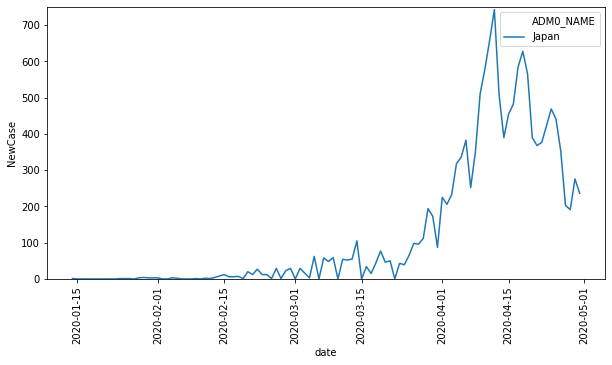

In [25]:
# fig, ax = plt.subplots(figsize=(20, 10))

fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xticklabels('', rotation=90)
plt.xticks(rotation=90)

y_max = int((int(df_graph['NewCase'].max() / 50) + 1) * 50)
ax.set(ylim = (0, y_max))

sns.lineplot(
    ax=ax,
    data=df_graph,
    x=DATE_FIELD,
    y='NewCase',
    hue=COUNTRY_FIELD)

## 国指定、日付ごと累計感染者数

In [26]:
# query = 'residence_pref in %s' % json.dumps(PREF)
query = '%s in %s' % (COUNTRY_FIELD, json.dumps(COUNTRY),)
df_graph = df.query(query)

In [27]:
# df_graph.head()

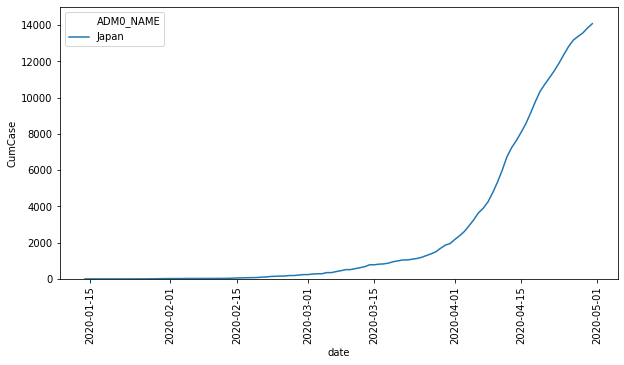

In [28]:
# fig, ax = plt.subplots(figsize=(20, 10))

fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xticklabels('', rotation=90)
plt.xticks(rotation=90)

y_max = int((int(df_graph['CumCase'].max() / 1000) + 1) * 1000)
ax.set(ylim = (0, y_max))

sns.lineplot(
    ax=ax,
    data=df_graph,
    x=DATE_FIELD,
    y='CumCase',
    hue=COUNTRY_FIELD)

## 日付指定、国ごと

In [29]:
query = '%s == %s' % (DATE_FIELD, json.dumps(query_date),)
df_graph = df.query(query).sort_values(['NewCase'], ascending=False)

In [30]:
df_graph.head()

,OBJECTID,ISO_2_CODE,ISO_3_CODE,ADM0_NAME,date_epicrv,NewCase,CumCase,NewDeath,CumDeath,Short_Name_ZH,Short_Name_FR,Short_Name_ES,Short_Name_RU,Short_Name_AR,date,id
11623,11624,US,USA,United States of America,2020-04-30T00:00:00.000Z,20517,1003974,1936,52428,美利坚合众国,États-Unis d'Amérique,Estados Unidos de América,Соединенные Штаты Америки,الولايات المتحدة الأمريكية,2020-04-30,11623.0
1534,1535,BR,BRA,Brazil,2020-04-30T00:00:00.000Z,5385,71886,474,5017,巴西,Brésil,Brasil,Бразилия,البرازيل,2020-04-30,1534.0
8581,8582,PE,PER,Peru,2020-04-30T00:00:00.000Z,2491,31190,72,854,秘鲁,Pérou,Perú,Перу,بيرو,2020-04-30,8581.0
2046,2047,CA,CAN,Canada,2020-04-30T00:00:00.000Z,1349,50363,138,2904,加拿大,Canada,Canadá,Канада,كندا,2020-04-30,2046.0
7220,7221,MX,MEX,Mexico,2020-04-30T00:00:00.000Z,1223,16752,135,1569,墨西哥,Mexique,México,Мексика,المكسيك,2020-04-30,7220.0


In [31]:
# [DEBUG] ファイルの最終日付における、国別の新規感染者数を一覧表示
for idx, row in df_graph.iterrows():
    fix_date = datetime.datetime.strftime(row[DATE_FIELD], '%Y-%m-%d')
    print('%s,%s,%d' % (fix_date,row[COUNTRY_FIELD],row['NewCase']))

2020-04-30,United States of America,20517
2020-04-30,Brazil,5385
2020-04-30,Peru,2491
2020-04-30,Canada,1349
2020-04-30,Mexico,1223
2020-04-30,Singapore,690
2020-04-30,Chile,520
2020-04-30,Ecuador,417
2020-04-30,South Africa,354
2020-04-30,Colombia,352
2020-04-30,Philippines,254
2020-04-30,Dominican Republic,236
2020-04-30,Japan,236
2020-04-30,Algeria,199
2020-04-30,Nigeria,195
2020-04-30,Argentina,182
2020-04-30,United Republic of Tanzania,180
2020-04-30,Panama,179
2020-04-30,Guinea,111
2020-04-30,Cameroon,101
2020-04-30,Malaysia,94
2020-04-30,Senegal,59
2020-04-30,Mali,58
2020-04-30,Côte d’Ivoire,55
2020-04-30,Bolivia (Plurinational State of),39
2020-04-30,Gabon,38
2020-04-30,Honduras,36
2020-04-30,Puerto Rico,33
2020-04-30,El Salvador,32
2020-04-30,Cuba,30
2020-04-30,Guatemala,27
2020-04-30,Eswatini,20
2020-04-30,Jamaica,17
2020-04-30,Congo,13
2020-04-30,Rwanda,13
2020-04-30,Sierra Leone,12
2020-04-30,Kenya,10
2020-04-30,Togo,10
2020-04-30,Paraguay,9
2020-04-30,Democratic Republic o

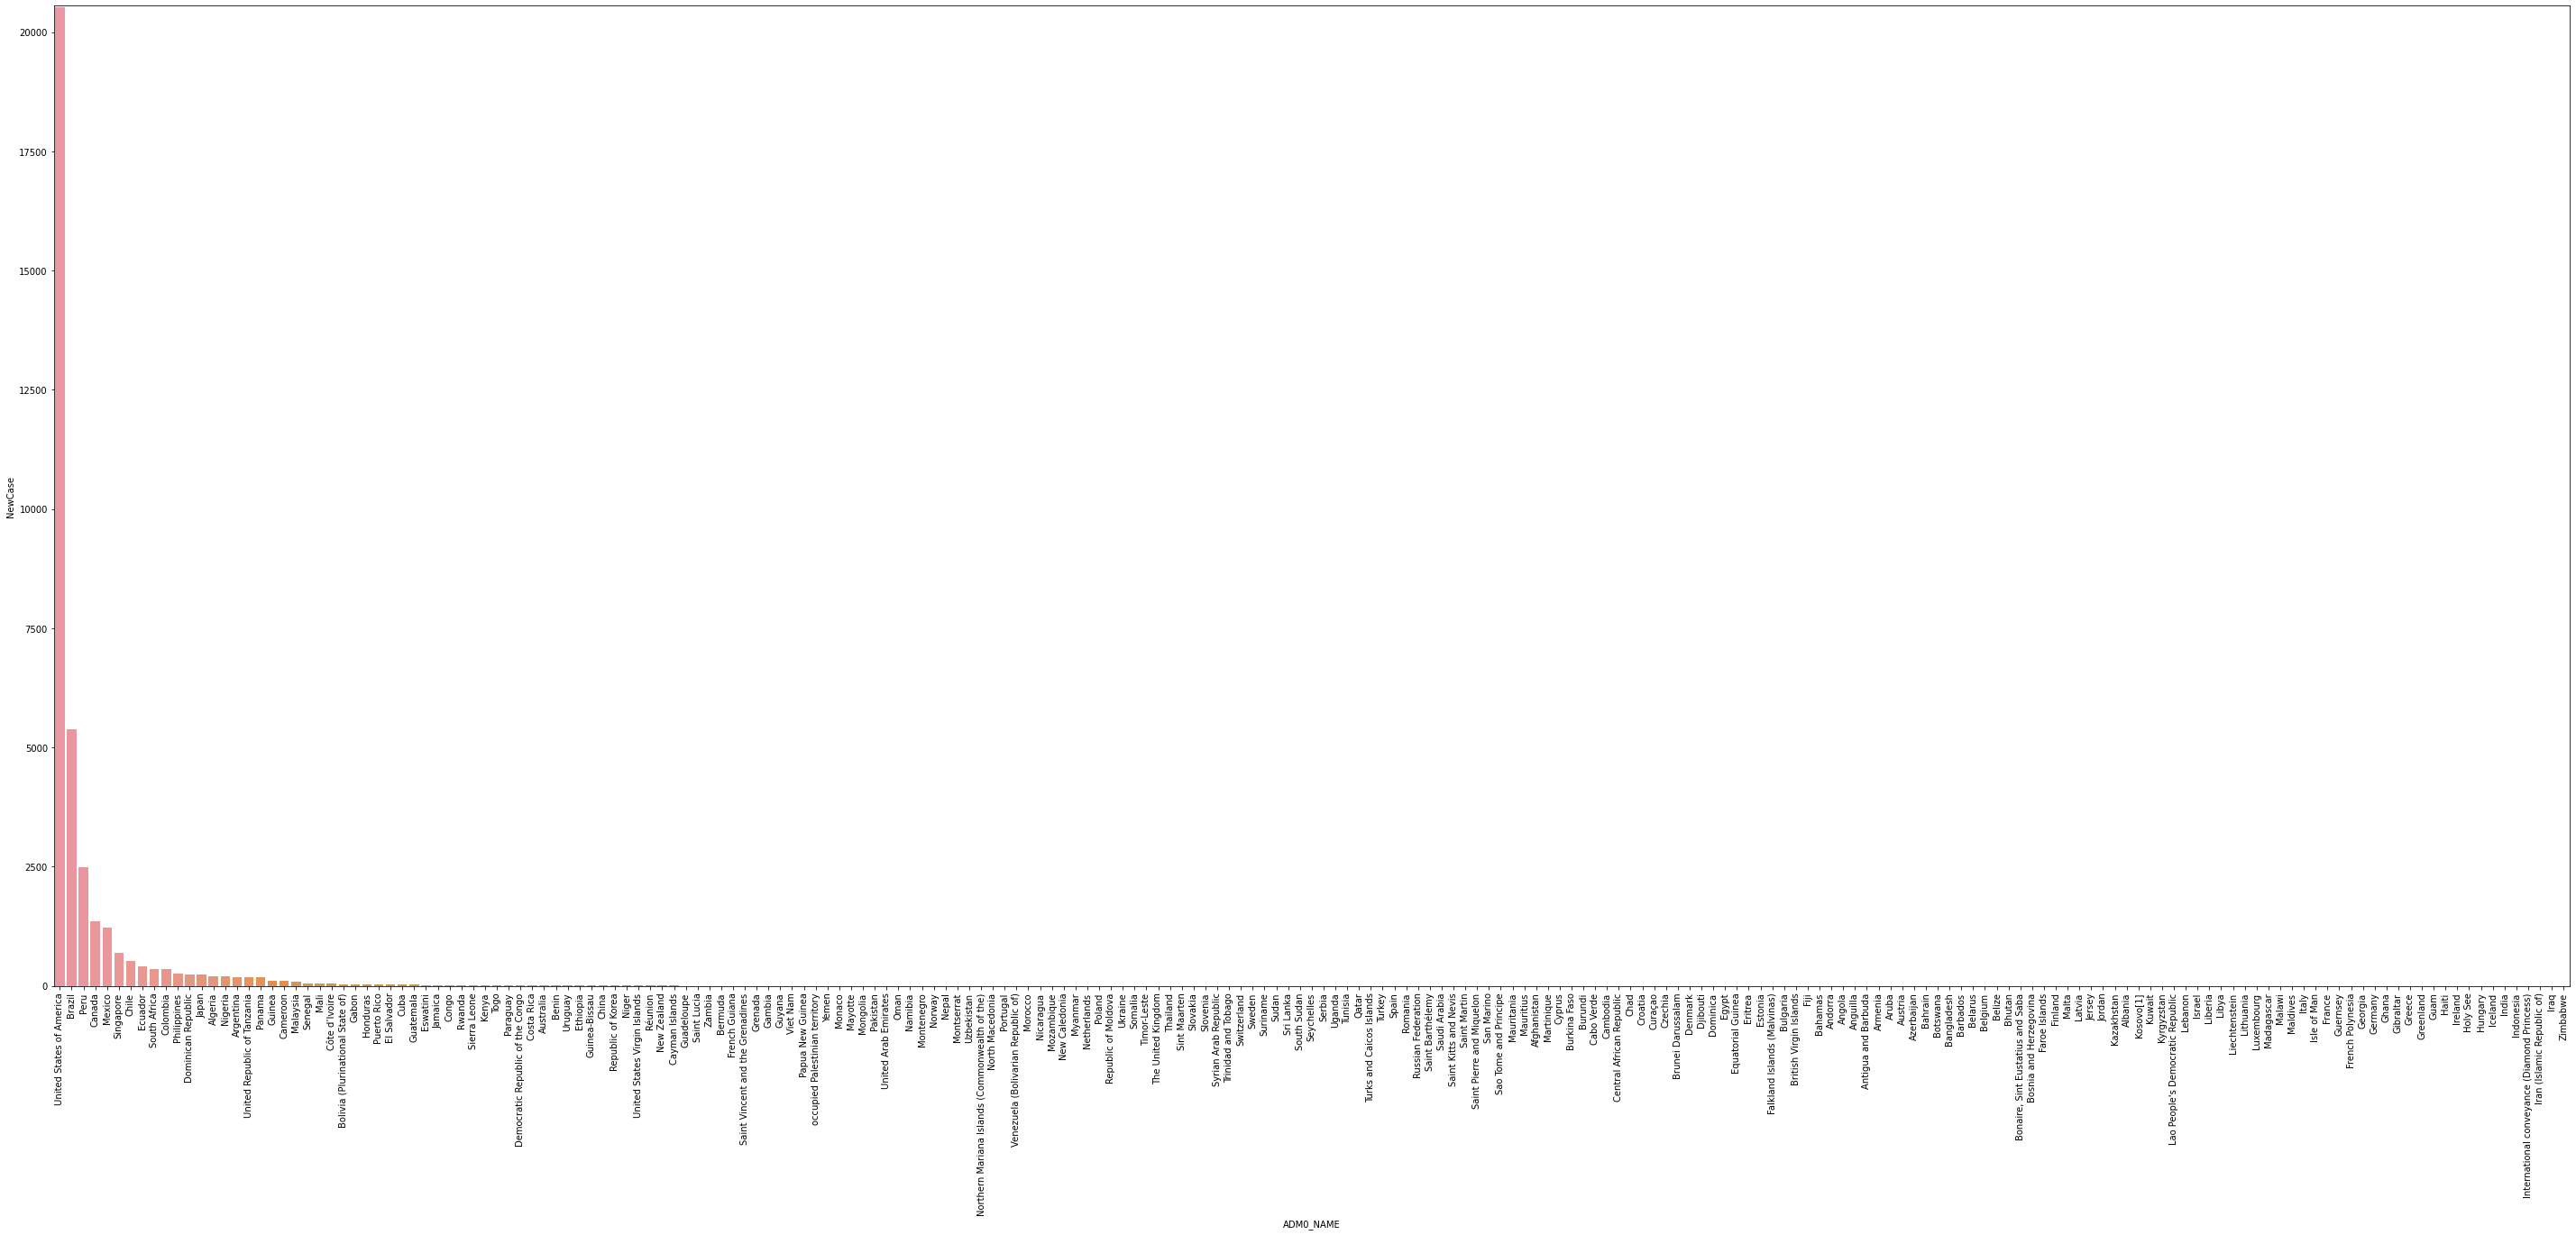

In [32]:
# fig, ax = plt.subplots(figsize=(20, 10))

fig, ax = plt.subplots(figsize=(50, 20))
# ax.set_xticklabels('', rotation=90)
plt.xticks(rotation=90)

y_max = (int(df_graph['NewCase'].max() / 50) + 1) * 50
ax.set(ylim = (0, y_max))

sns.barplot(
    ax=ax,
    data=df_graph,
    x=COUNTRY_FIELD,
    y='NewCase')

In [33]:
print('query_date : %s' % (query_date,))

query_date : 2020-04-30
